In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors

import numpy as np
import random

import time
import pandas as pd
from IPython.display import clear_output

In [2]:
# agent sorting:
# agent_list.sort(key=lambda agent_this: (agent_this[4], agent_this[0]))

# What it needs to do:
# - Manage cars in and out of rest area (done)
# - Count how many cars in rest area (soon)
# - Display in another color for rest area (nope)
# - First accident: out of highway
# - Out from accident

In [26]:
# Drowse 40 starts to get drowsy
# Status [1, 2, 3, 4]: 1 is on road, 2 is in ra, 3 is arrived to destionation, 4 is having an accident

direct_ways = [0, 1, 2, 3, 4, 5, 6, 7, 8] # top_right=1, right=2, bot_right=3

# misc. stuff
def grid_0(length, width):
    grid_base = [[0 for _ in range(length)] for _ in range(width)]
    return grid_base

def print_grid(grid):
    for row in reversed(grid):
        print(row)

# these are important
class Grid:
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.grid = [[0 for _ in range(length)] for _ in range(width)]

    def show_grid(self):
        return self.grid

class Environment:
    def __init__(self, length, width):
        self.grid = [[0 for _ in range(length)] for _ in range(width)]
        self.grid_ra = [[0 for _ in range(length)] for _ in range(width)]

    def add_lane(self, start_x, length_x, pos_y):
        for x in range(0, length_x):
            self.grid[pos_y][x + start_x] = 1

    def add_ra(self, pos_x, pos_y):
        self.grid[pos_y][pos_x] = 2
        self.grid_ra[pos_y][pos_x] = 2

    def show_grid(self):
        return self.grid

    def show_grid_ra(self):
        return self.grid_ra

class Agent:
    def __init__(self, class_env):
        self.grid_env = class_env.show_grid()
        self.length = len(self.grid_env[0])
        self.width = len(self.grid_env)
        self.grid_agents = [[0 for _ in range(self.length)] for _ in range(self.width)]
        self.agent_ID = 0
        self.list_agents = []
    
    def create(self, pos_x, pos_y, drowse, directions, status):
        agent = [pos_x, pos_y, drowse, directions, status, (self.agent_ID+1)]
        self.list_agents.append(agent)
        self.agent_ID += 1
        return agent

    def size_grid(self):
        return self.length, self.width

    def drowse_random(self):
        return random.randint(0, 50)

    # I think accident should be put here

    def show_grid(self):
        self.grid_agents = [[0 for _ in range(self.length)] for _ in range(self.width)]
        for agent in range(len(self.list_agents)):
            try: 
                x, y = self.list_agents[agent][0], self.list_agents[agent][1]
                status = self.list_agents[agent][4]
                drowse = self.list_agents[agent][2] # depends of how drowsy
                if status != 4:
                    # drowse level
                    if drowse >= 100:
                        self.grid_agents[y][x] = 3 # 3 for distinctive
                    elif drowse >= 60:
                        self.grid_agents[y][x] = 2 # 2 for distinctive
                    elif drowse < 60:
                        self.grid_agents[y][x] = 1
            except: # If this agent is already arrived
                continue
        return self.grid_agents

    def show_agents(self):
        return self.list_agents # might be useful

    def create_init_random(self, n):
        random.seed(42)
        # All coordinates that satisfy the constraint
        eligible = [
            (r, c)
            for r, row in enumerate(self.grid_env)
            for c, v   in enumerate(row)
            if v == 1
        ]
        #print(eligible)
        if n > len(eligible):
            raise ValueError(
                f"Only {len(eligible)} eligible spots, but you asked for {n} agents."
            )
        for pos_y, pos_x in random.sample(eligible, n):
            #print(pos_y, pos_x)
            agent = Agent.create(self, pos_x, pos_y, 0, 2, 1)
        return self.list_agents
        
    def create_one_random(self):
        random.seed(None)
        # All coordinates that satisfy the constraint
        c = 0 # column or pos_x 0
        eligible = [
            (r, c)
            for r, row in enumerate(self.grid_env)
            if row[c] == 1 and self.grid_agents[r][c] == 0
        ]
        #print(eligible)
        rn_spawn = random.random()
        #print(rn_spawn)
        if rn_spawn >= 0.5 and len(eligible) > 0:
            for pos_y, pos_x in random.sample(eligible, 1):
                #print(pos_y, pos_x)
                agent = Agent.create(self, pos_x, pos_y, Agent.drowse_random(self), 2, 1)
        return self.list_agents

# under construction
class RA_processes:
    def __init__(self, class_agent, class_env):
        self.A = class_agent
        self.E = class_env
        self.grid_size = self.A.size_grid()
        self.RA_list = []
        self.RA_total = []
        grid_env = self.E.show_grid()
        for r, row in enumerate(grid_env):
            for c, v in enumerate(row):
                if v == 2:
                    ra_loc = [c, r]
                    self.RA_list.append(ra_loc)
                    self.RA_total.append([ra_loc, 0])

    def resting(self):
        pass

    def status_change(self, agent_this):
        grid_env = self.E.show_grid()
        x, y = agent_this[0], agent_this[1]

        if agent_this[4] != 4:
            for j in range(len(self.RA_list)):
                RA_this = self.RA_list[j]
                if x == RA_this[0] and y == RA_this[1]:
                    if agent_this[4] == 1: # went from a lane
                        self.RA_total[j][-1] += 1 # counter
                        
                    agent_this[4] = 2
    
            if x < self.grid_size[0]: # still in the grid
                if grid_env[y][x] == 1: # if on the highway
                    agent_this[4] = 1
            else:
                agent_this[4] = 3
            
    def ra_in(self): # which cars are in rest area
        agent_list = self.A.show_agents()
        ra_agents = [agent_this for agent_this in agent_list if agent_this[4] == 2] # agents in rest area
        return len(ra_agents)

    def rest(self, agent_this):
        if agent_this[2] >= 10:
            agent_this[2] -= 3
        if agent_this[2] < 0:
            agent_this[2] == 0
    
    def ra_out_rn(self, agent_this):
        random.seed(None)
        ra_out = 0
        drowse = agent_this[2]
        rn_out = random.random()
        if drowse < 10 and rn_out >= 0.5:
            ra_out = 1
        return ra_out

    def visitor_all(self):
        visitor = 0
        for i in range(len(self.RA_total)):
            visitor += self.RA_total[i][-1]
        return visitor

    def visitor_each(self):
        return self.RA_total

class Accident: # anything related to accident (out of highway, collision)
    def __init__(self, class_agent, class_env): # needs environment and agent details, particularly position
        self.A = class_agent
        self.E = class_env
        self.grid_size = self.A.size_grid()
        self.time = 1
        self.accident_record = []
        self.accident_text = []

    def check_out(self, agent_this):
        agent_list = self.A.show_agents()
        grid_env = self.E.show_grid()
        
        pos_x = agent_this[0]
        pos_y = agent_this[1]
        ID = agent_this[-1]

        if pos_x >= self.grid_size[0] or agent_this[4] == 4:
            pass # no check for finish or after having an accident

        elif (pos_x) < self.grid_size[0] and agent_this[4] == 1: # driving?
            # out from the highway
            if grid_env[pos_y][pos_x] == 0:
                
                new_accident = [self.time, agent_this, 0]
                self.accident_record.append(new_accident)

                acc_text = f"{self.time} - Car {ID} is out of the highway at ({pos_x}, {pos_y})"
                self.accident_text.append(acc_text)
                
                agent_this[4] = 4
                
            # collide with other agent
            collided = 0 # checker, prevents duplicate
            for j in range(len(agent_list)):
                agent_that = agent_list[j]
                pos_x_that = agent_that[0]
                pos_y_that = agent_that[1]
                ID_that = agent_that[-1]
    
                if (pos_x != pos_x_that and pos_y != pos_y_that):
                    continue
    
                elif (pos_x == pos_x_that and 
                      pos_y == pos_y_that and 
                      ID != ID_that and 
                      grid_env[pos_y][pos_x] == 1): # make sure it's on the highway

                    if collided == 0:
                        new_accident = [self.time, agent_this, agent_that, 0] # last element is timer
                        self.accident_record.append(new_accident)
    
                        acc_text = f"{self.time} - Car {ID} {agent_this[4], agent_this[2]} and {ID_that} {agent_that[4], agent_that[2]} has the collision at ({pos_x}, {pos_y})"
                        self.accident_text.append(acc_text)
                        
                        agent_this[4], agent_that[4] = 4, 4
    
                        collided += 1

    def count(self):
        out = 0
        collide = 0
        for i in range(len(self.accident_record)):
            if len(self.accident_record[i]) == 3:
                out += 1
            elif len(self.accident_record[i]) == 4:
                collide += 1
        return out, collide

    def print_count(self):
        print(self.accident_record)

    def print_text(self):
        for i in range(len(self.accident_text)):
            print(self.accident_text[i])

    def duration(self):
        self.time += 1
        for i in range(len(self.accident_record)):
            time_here = self.accident_record[i][-1]
            if time_here < 10:
                self.accident_record[i][-1] += 1 # accident creates obstacles

    def show_grid(self):
        grid_accident = [[0 for _ in range(self.grid_size[0])] for _ in range(self.grid_size[1])]

        for i in range(len(self.accident_record)):
            time_here = self.accident_record[i][-1]
            #print(self.accident_record)
            x, y = self.accident_record[i][1][0], self.accident_record[i][1][1]
            if time_here < 10: # will show if 
                grid_accident[y][x] = 4

        return grid_accident
        
class Visualization:
    def __init__(self, class_agents, class_env, class_acc): #requires environment and agent classes
        self.A_grid = class_agents.show_grid()
        self.E_grid = class_env.show_grid()
        self.RA_grid = class_env.show_grid_ra()
        self.ACC_grid = class_acc.show_grid()

        # separate grid for rest area and accidents will be also here
    
    def plot(self):
        length = len(self.A_grid[0])
        width = len(self.A_grid)
        
        # black = crash, death, whatever
        colormap_E = colors.ListedColormap(["green", "grey", "skyblue"])
        colormap_A = colors.ListedColormap(["none", "blue", "orange", 
                                            "red", "black"]) # [0, 1, 2, 3, 4]
        colormap_RA = colors.ListedColormap(["none", "none", "skyblue"])
        
        plt.figure(figsize=(14,8))
        plt.imshow(self.E_grid, cmap=colormap_E, vmin=0, vmax=2, 
                   aspect='equal', origin='lower')
        plt.imshow(self.A_grid, cmap=colormap_A, vmin=0, vmax=4, 
                   aspect='equal', origin='lower')
        plt.imshow(self.ACC_grid, cmap=colormap_A, vmin=0, vmax=4, 
                   aspect='equal', origin='lower')
        plt.imshow(self.RA_grid, cmap=colormap_RA, vmin=0, vmax=2, 
                   aspect='equal', origin='lower')
        ax = plt.gca()
        
        # Major ticks
        ax.set_xticks(np.arange(0, length, 2))
        ax.set_yticks(np.arange(0, width, 2))
        
        # Minor ticks
        ax.set_xticks(np.arange(-.5, length, 1), minor=True)
        ax.set_yticks(np.arange(-.5, width, 1), minor=True)
        
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
        
        # Remove minor ticks
        ax.set_xticklabels([])    # ✓ Hides X-axis numbers
        ax.set_yticklabels([])    # ✓ Hides Y-axis numbers
        ax.tick_params(which='minor', bottom=False, left=False, labelbottom=False, labelleft=False)

        plt.show()

class Movement:
    def __init__(self, class_agent, class_env, class_acc, class_ra):
        self.A = class_agent
        self.E = class_env
        self.ACC = class_acc
        self.RA = class_ra
        self.grid_size = self.A.size_grid()
        #self.grid_size[0] = length of the grid (x)

    def move_now(self, agent_this):

        grid_env = self.E.show_grid()
        
        if agent_this[4] != 4 and agent_this[0] < self.grid_size[0]: # as long as the agent is not having an accident
            if agent_this[3] == 2: # direction
                agent_this[0] += 1 # move forward
        
            elif agent_this[3] == 1:
                agent_this[0] += 1
                agent_this[1] += 1 # change y position (left)
        
            elif agent_this[3] == 3:
                agent_this[0] += 1
                agent_this[1] -= 1 # change y position (right)
            
            if agent_this[4] == 1: # status is driving?
                agent_this[2] += 1 # # drowse, can even being drowsy when having traffic jam
                
    def move_none(self, agent_this): # stop, agent doesn't move
        pass

    def direction_aware(self, agent_this):
        grid_agents = self.A.show_grid() # for grid update thingy
        grid_acc = self.ACC.show_grid() # show accidents
        #agent_list = self.A.show_agents()
        
        dir_list = [1, 2, 2, 2, 2, 2, 2, 3] # 75% straight

        if agent_this[2] >= 60:
            dir_list = [1, 2, 2, 2, 3] # 60% straight

        # drowsy driver has all directions available (has a chance to move away from the highway)
        if agent_this[2] >= 100:
            dir_list = [0, 1, 2, 2, 2, 3] # 50% straight, chance to stop
        
        pos_x = agent_this[0]
        pos_y = agent_this[1]
        ID = agent_this[-1]

        grid_env = self.E.show_grid()
            
        if (pos_x < self.grid_size[0] and 
            1 <= grid_env[pos_y][pos_x] <= 2 and 
            agent_this[4] <= 2 and 
            agent_this[2] < 100): # still in the grid and on the highway or RA and not too drowsy

            if (pos_x + 1) < self.grid_size[0]: # a bit far from finish
                
                agent_left = grid_agents[pos_y+1][pos_x+1] # check front left
                agent_front = grid_agents[pos_y][pos_x+1] # check front
                agent_right = grid_agents[pos_y-1][pos_x+1] # check front right
    
                # another active agent nearby
                if 1 <= agent_front <= 3 and grid_env[pos_y][pos_x+1] == 1: # another agent on the highway
                    dir_list = [x for x in dir_list if x != 2] # no go straight
                    
                if 1 <= agent_left <= 3 and grid_env[pos_y+1][pos_x+1] == 1: # another agent on the highway
                    dir_1 = dir_list.count(1)
                    dir_3 = dir_list.count(3)
                    if dir_3 != 0:
                        dir_list.extend([3]*dir_1)
                    dir_list = [x for x in dir_list if x != 1] # no turn left
    
                if 1 <= agent_right <= 3 and grid_env[pos_y-1][pos_x+1] == 1: # another agent on the highway
                    dir_1 = dir_list.count(1)
                    dir_3 = dir_list.count(3)
                    if dir_1 != 0:
                        dir_list.extend([1]*dir_3)
                    dir_list = [x for x in dir_list if x != 3] # no turn right
    
                # accidents, man
                obs_left = grid_acc[pos_y+1][pos_x+1] # check front left
                obs_front = grid_acc[pos_y][pos_x+1] # check front
                obs_right = grid_acc[pos_y-1][pos_x+1] # check front right

                # another obstacle agent nearby
                if obs_front == 4 and grid_env[pos_y][pos_x+1] == 1: # another agent on the highway
                    dir_list = [x for x in dir_list if x != 2] # no go straight
                
                if obs_left == 4 and grid_env[pos_y+1][pos_x+1] == 1: # another agent on the highway
                    dir_1 = dir_list.count(1)
                    dir_3 = dir_list.count(3)
                    if dir_3 != 0:
                        dir_list.extend([3]*dir_1)
                    dir_list = [x for x in dir_list if x != 1] # no turn left
    
                if obs_right == 4 and grid_env[pos_y-1][pos_x+1] == 1: # another agent on the highway
                    dir_1 = dir_list.count(1)
                    dir_3 = dir_list.count(3)
                    if dir_1 != 0:
                        dir_list.extend([1]*dir_3)
                    dir_list = [x for x in dir_list if x != 3] # no turn right
                        
                # no sides
                if grid_env[pos_y][pos_x+1] == 0: # no road in front of you
                    dir_list = [x for x in dir_list if x != 2] # no go straight
                    
                if grid_env[pos_y+1][pos_x+1] == 0: # no road on left
                    dir_1 = dir_list.count(1)
                    dir_3 = dir_list.count(3)
                    if dir_3 != 0:
                        dir_list.extend([3]*dir_1)
                    dir_list = [x for x in dir_list if x != 1] # no turn left
                
                if grid_env[pos_y-1][pos_x+1] == 0: # no road on right
                    dir_1 = dir_list.count(1)
                    dir_3 = dir_list.count(3)
                    if dir_1 != 0:
                        dir_list.extend([1]*dir_3)
                    dir_list = [x for x in dir_list if x != 3] # no turn right
    
                # can't move
                if len(dir_list) == 0: # no move direction
                    dir_list = [0]

            else: # near the end
                dir_list = [2]

        #rest area on left
        if (pos_x + 1) < self.grid_size[0] and agent_this[2] >= 60:  #if drowsy enough
            if grid_env[pos_y+1][pos_x+1] == 2:
                dir_0 = dir_list.count(0)
                dir_1 = dir_list.count(1)
                dir_2 = dir_list.count(2)
                dir_3 = dir_list.count(3)
                add_1 = dir_0 + dir_2 + dir_3 - dir_1
    
                if dir_1 != 0: # make sure not to add left when no roads
                    dir_list.extend([1]*(add_1*3)) # 75% chance to enter rest area
        
        # having an accident
        if pos_x < self.grid_size[0] and (grid_env[pos_y][pos_x] == 0 or agent_this[4] == 4):
            dir_list = [0]

        # not in the grid (already finish)
        elif pos_x >= self.grid_size[0]:
            dir_list = [0]

        dir_new = random.choice(dir_list)
            
        agent_this[3] = dir_new

    def record(self): # record agents
        pass
        
    def move_one(self):
        agent_list = self.A.show_agents()

        # randoming first (helps with randomized pos_y)
        random.shuffle(agent_list)
        # sort by status first [4] (ascending), then pos_x [0] (descending)
        agent_list.sort(key=lambda agent_this: (agent_this[4], -agent_this[0])) # sort on status (where), then pos_x
        
        grid_agents = self.A.show_grid() # for grid update thingy
        grid_env = self.E.show_grid()
        
        #agent_list_new = [] #                                                -> for the next iteration
        for i in range (len(agent_list)):
            agent_this = agent_list[i]
            # If on the highway
            if agent_this[4] == 1: # status: is driving
                Movement.direction_aware(self, agent_this)
                Movement.move_now(self, agent_this)
                #Movement.direction_next(self, agent_this)

            # In rest area:
            if agent_this[4] == 2:
                if self.RA.ra_out_rn(agent_this) == 1:
                    Movement.direction_aware(self, agent_this)
                    Movement.move_now(self, agent_this)
                else:
                    self.RA.rest(agent_this)

            # Accident
            self.ACC.check_out(agent_this)
            
            self.RA.status_change(agent_this)
            
        self.ACC.duration()
            
        print("In rest area:", self.RA.ra_in())

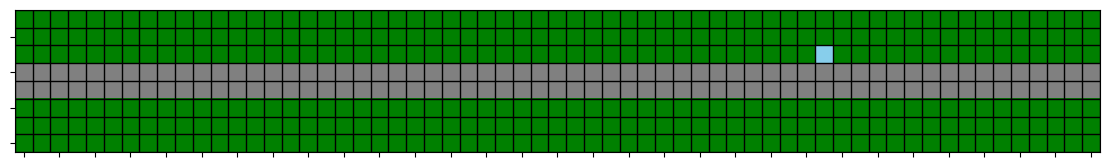

In [29]:
# Make grid (empty)
Time = 50
nCars = 0
length = 61
width = 8

Env = Environment(length, width)

"""
for i in range(3):
    Env.add_ra(20*(i+1) - 10, 5)
"""

Env.add_lane(0, length, 3)
Env.add_lane(0, length, 4)
Env.add_ra(45, 5)

grid_Env = Env.show_grid()
Cars = Agent(Env)
Acc = Accident(Cars, Env)
RA = RA_processes(Cars, Env)
Mov = Movement(Cars, Env, Acc, RA)
t = 0
Visualization(Cars, Env, Acc).plot()

In rest area: 4


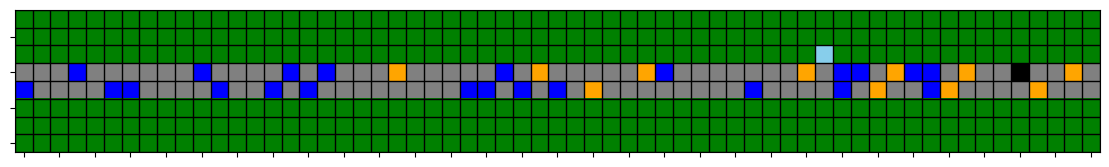

90 - Car 18 is out of the highway at (51, 5)
101 - Car 23 is out of the highway at (55, 2)
102 - Car 20 is out of the highway at (58, 5)
138 - Car 39 (1, 107) and 43 (1, 96) has the collision at (56, 4)

- Agents deployed: 75
- Accidents: 3 out of highway, 1 collision
- Time: 137
[[3, 1, 10]]


In [28]:
# Make grid (with 1 rest area)

Time = 50
nCars = 75

length = 61
width = 8

Env = Environment(length, width)

"""
for i in range(3):
    Env.add_ra(20*(i+1) - 10, 5)
"""

Env.add_lane(0, length, 3)
Env.add_lane(0, length, 4)
Env.add_ra(45, 5)

grid_Env = Env.show_grid()
#print_grid(grid_Env)

full_data = []

# Simulation
for repeat in range(1):
    Cars = Agent(Env)
    Acc = Accident(Cars, Env)
    RA = RA_processes(Cars, Env)
    Mov = Movement(Cars, Env, Acc, RA)
    t = 0
    while len(Cars.show_agents()) < nCars:
        Mov.move_one()
        Cars.create_one_random() # chance to add one agent
        Visualization(Cars, Env, Acc).plot()
        #print(Acc.count())
        Acc.print_text()
        #print(Cars.show_agents())
        # Refresh output
    
        accident = Acc.count()
        print()
        #print("Result:")
        print("- Agents deployed:", len(Cars.show_agents()))
        print("- Accidents:", accident[0], "out of highway,", accident[1], "collision")
        print("- Time:", t)
        t += 1
    
        #time.sleep(0.05)
        if len(Cars.show_agents()) < nCars:
            clear_output(wait=True)

    full_data.append([accident[0], accident[1], RA.visitor_all()])

print(full_data)

# Create DataFrame
df = pd.DataFrame(full_data, columns=['acc_out', 'acc_collide', 'ra_visits'])
# Save to CSV
#df.to_csv('test_1_ra.csv', index=False)